<a href="https://colab.research.google.com/github/mobinapourmoshir/Functional-Deep-Learning/blob/main/Convolutional_Autoencoder_With_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Convolutional Autoencoder**

To enable GPU, you need to change runtime type from Runtime section in the menu section above in colab!

In [1]:
import tensorflow as tf, subprocess, sys
print("TF:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))
!nvidia-smi


TF: 2.19.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Wed Nov 12 19:14:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |             

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled.")
    except Exception as e:
        print("Could not set memory growth:", e)
else:
    print("No GPU detected by TF.")


Memory growth enabled.


In [3]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')  # optional speed boost

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.4480 - val_loss: 0.3024
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2959 - val_loss: 0.2898
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2864 - val_loss: 0.2845
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2810 - val_loss: 0.2814
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2796 - val_loss: 0.2794
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2767 - val_loss: 0.2779
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2752 - val_loss: 0.2767
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2742 - val_loss: 0.2758
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2739 - val_loss: 0.2750
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2726 - val_loss: 0.2743
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2715 - val_loss: 0.2737
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/st

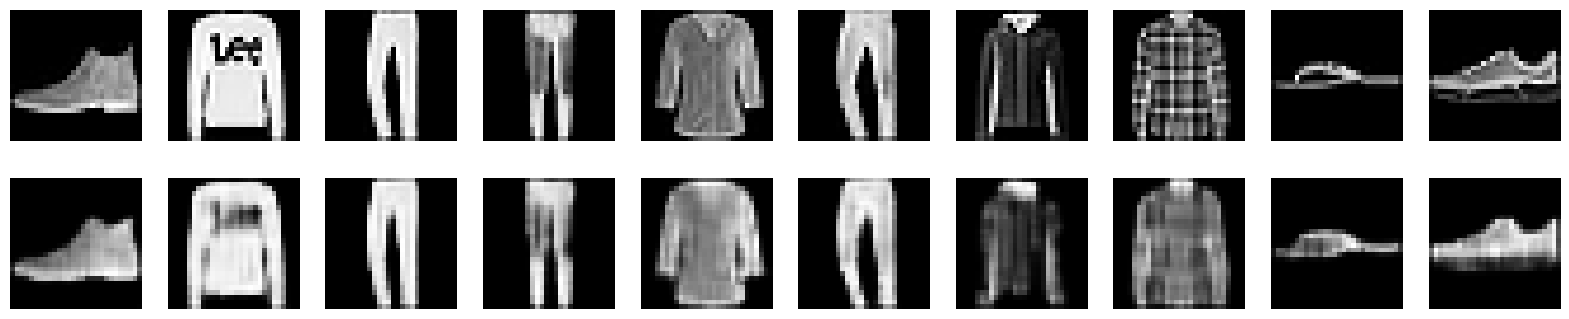

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist

(x_train, _), (x_test, _) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train_flat = x_train.reshape(len(x_train), 784)
x_test_flat = x_test.reshape(len(x_test), 784)

n = 10
input_img = tf.keras.Input(shape=(28, 28, 1))

x = tf.keras.layers.Conv2D(
    16, (3, 3), activation='relu', padding='same')(input_img)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

x = tf.keras.layers.Conv2D(
    8, (3, 3), activation='relu', padding='same')(encoded)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
decoded = tf.keras.layers.Conv2D(
    1, (3, 3), activation='sigmoid', padding='same')(x)

conv_autoencoder = tf.keras.Model(input_img, decoded)
conv_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

x_train_cnn = x_train.reshape(-1, 28, 28, 1)
x_test_cnn = x_test.reshape(-1, 28, 28, 1)

conv_autoencoder.fit(x_train_cnn, x_train_cnn,
                     epochs=50,
                     batch_size=256,
                     shuffle=True,
                     validation_data=(x_test_cnn, x_test_cnn))

decoded_imgs = conv_autoencoder.predict(x_test_cnn)

plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_cnn[i].reshape(28, 28), cmap='gray')
    ax.axis('off')

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    ax.axis('off')
plt.show()